In [169]:
from PIL import Image
from wand.image import Image as wandImage
from wand.color import Color
from mrjob.job import MRJob
import cv2
import csv
import PyPDF2
import pytesseract
import argparse
import io
import numpy as np
import pandas as pd
import tempfile
import pickle
import boto3
import multiprocessing
import matplotlib.pyplot as plt
import itertools
import intervals
%matplotlib inline

def pdfPageToImg(src_pdf, pagenum, resolution=300, preprocess="thresh"):

    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))
    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    img_buffer=None

    with wandImage(file = pdf_bytes, resolution = resolution) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    return gray
    #return Image.fromarray(gray)

def categorizeTwoColumnBlocks(contents):
    blockstats = contents['blockstats']
    paragraphs = contents['paragraphs']
    data = contents['data']
    boxes = contents['boxes']
    
    header = blockstats[(blockstats.bottom_at < blockstats.bottom_at.max()*0.1) & (blockstats.n_par < 2)].sort_values(by='left_at')
    leftcol = blockstats[(blockstats.right_at < blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='left_at')
    rightcol = blockstats[(blockstats.right_at > blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='top_at')
    footer = blockstats[(blockstats.top_at > blockstats.bottom_at.max()*0.9) & (blockstats.n_par < 2)].sort_values(by='top_at')

    blocks = {'header':header,'footer':footer,'leftcol':leftcol,'rightcol':rightcol}

    paragraphs = {'header':list(itertools.chain.from_iterable([paragraphs[i] for i in header.index])),
                  'footer':list(itertools.chain.from_iterable([paragraphs[i] for i in footer.index])),
                  'leftcol':list(itertools.chain.from_iterable([paragraphs[i] for i in leftcol.index])),
                  'rightcol':list(itertools.chain.from_iterable([paragraphs[i] for i in rightcol.index]))
                 }

#     data = {'header':list(itertools.chain.from_iterable([data[i] for i in header.index])),
#             'footer':list(itertools.chain.from_iterable([data[i] for i in footer.index])),
#             'leftcol':list(itertools.chain.from_iterable([data[i] for i in leftcol.index])),
#             'rightcol':list(itertools.chain.from_iterable([data[i] for i in rightcol.index]))
#            }

#     boxes = {'header':list(itertools.chain.from_iterable([boxes[i] for i in header.index])),
#              'footer':list(itertools.chain.from_iterable([boxes[i] for i in footer.index])),
#              'leftcol':list(itertools.chain.from_iterable([boxes[i] for i in leftcol.index])),
#              'rightcol':list(itertools.chain.from_iterable([boxes[i] for i in rightcol.index]))
#             }

    mergedblocks = {}
    for k in blocks.keys():
        summary = {}
        summary['top_at'] = blocks[k].top_at.min()
        summary['bottom_at'] = blocks[k].bottom_at.max()
        summary['left_at'] = blocks[k].left_at.min()
        summary['right_at'] = blocks[k].right_at.max()
        summary['width'] = summary['right_at'] - summary['left_at']
        summary['height'] = summary['bottom_at'] - summary['top_at']
        mergedblocks[k] = summary
    
    return {'mergedblocks':mergedblocks,
            'blockstats':blocks,
            'paragraphs':paragraphs,
            'data':data,
            'boxes':boxes
           }


def drawBlocks(gray, pagecontents, preprocess="thresh"):

    blockstats = pagecontents['blockstats']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    return img_blocks
        
def drawMergedBlocks(gray, pagecontents, preprocess="thresh"):

    mergedblocks = pagecontents['mergedblocks']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in mergedblocks.items():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)
        
    return img_blocks

def loadAllData(contentsFile, pdfFile):
    contents = pickle.load( open( contentsFile, "rb" ) )
    src_pdf = PyPDF2.PdfFileReader(pdfFile)
    return {'contents': contents, 'pdf': src_pdf}

def findIntervals(row, direction = 0):
    if direction == 0:
        return pd.Interval(left=row['top_at'], right=row['bottom_at'], closed='both')
    else:
        return pd.Interval(left=row['left_at'], right=row['right_at'], closed='both')

def pageBlockIntervals(contents, direction=0):
    return contents.apply(lambda row: findIntervals (row, direction),axis=1)

def mergeIntervals(intv):
    # 1. Sort the intervals based on increasing order of starting time.
    # 2. Push the first interval onto the stack.
    # 3. For each interval:
    #    a. If the current interval does not overlap with the top of the stack, push it.
    #    b. If the current interval overlaps with stack top and the ending time of the current
    #        interval is more than that of stack top, update stack top with the ending time of the current interval.
    # 4. When complete, the stack contains the merged intervals. 
    intvlist = list(intv.sort_values())
    stack = []
    stack.append(intvlist.pop(0))
    for i in range(len(intvlist)):
        int_1 = stack.pop()
        int_2 = intvlist[i]
        int_1i = intervals.closed(int_1.left, int_1.right) # pandas 0.23
        int_2i = intervals.closed(int_2.left, int_2.right) # pandas 0.23
        if int_1i.overlaps(int_2i):  # pandas 0.23
#        if int_1.overlaps(int_2):  # pandas 0.24, when 'overlaps' becomes available
            stack.append(pd.Interval(left=int_1.left, right=max(int_1.right, int_2.right),
                                     closed='both'))
        else:
            stack.append(int_1)
            stack.append(int_2)
    return stack

def findSection(section, blocks):
    block = None
    int_1 = section['ybounds']
    int_1i = intervals.closed(int_1.left, int_1.right) # pandas 0.23
    for i in range(len(blocks)):
        int_2 = blocks.iloc[i]['ybounds']
        int_2i = intervals.closed(int_2.left, int_2.right) # pandas 0.23       
        if int_2i.contains(int_1i): # pandas 0.23 intervals does not have 'contains' method
#        if int_2.contains(int_1): # for when 'contains' becomes available in pandas
            block = blocks.iloc[i].name
    return block
    
def addSectionAssignment(contents, pagenum):
    blocks = pd.DataFrame(pageBlockIntervals(contents[pagenum]['blockstats']), columns=["ybounds"])
    section = pd.DataFrame(mergeIntervals(blocks['ybounds']), columns=["ybounds"])
    section.index.name = "section"
    contents[pagenum]['blockstats']['section'] = pd.Categorical(blocks.apply(lambda row: findSection (row, section),axis=1))
    return contents[pagenum]

In [3]:
data = loadAllData(contentsFile="/Users/matt/Projects/ocr/1863Langley/contents.p",
                   pdfFile="/Users/matt/Projects/ocr/1863Langley/1863Langley.pdf")

In [135]:
x = pd.DataFrame(pageBlockIntervals(data['contents'][342]['blockstats']), columns=["ybounds"])
y = pd.DataFrame(mergeIntervals(x['ybounds']), columns=["ybounds"])
y.index.name = "section"
data['contents'][342]['blockstats']['section'] = assignBlocksToSections(x, y)

In [218]:
cont2 = addSectionAssignment(data['contents'], 340)
cont2['blockstats']['width'] = cont2['blockstats'].right_at - cont2['blockstats'].left_at
cont2['blockstats']['height'] = cont2['blockstats'].bottom_at - cont2['blockstats'].top_at
cont2['blockstats']

,n_par,n_line,top_at,bottom_at,left_at,right_at,section,width,height
block,,,,,,,,,
3,1,2,55,78,259,634,0,375,23
4,13,141,133,730,60,739,1,679,597
5,38,350,729,2369,61,741,1,680,1640
6,1,3,45,88,684,1146,0,462,43
7,1,1,48,79,1381,1442,0,61,31
8,25,231,133,1259,768,1448,1,680,1126
9,27,239,1245,2370,768,1449,1,681,1125
12,1,13,2403,2432,165,1350,2,1185,29


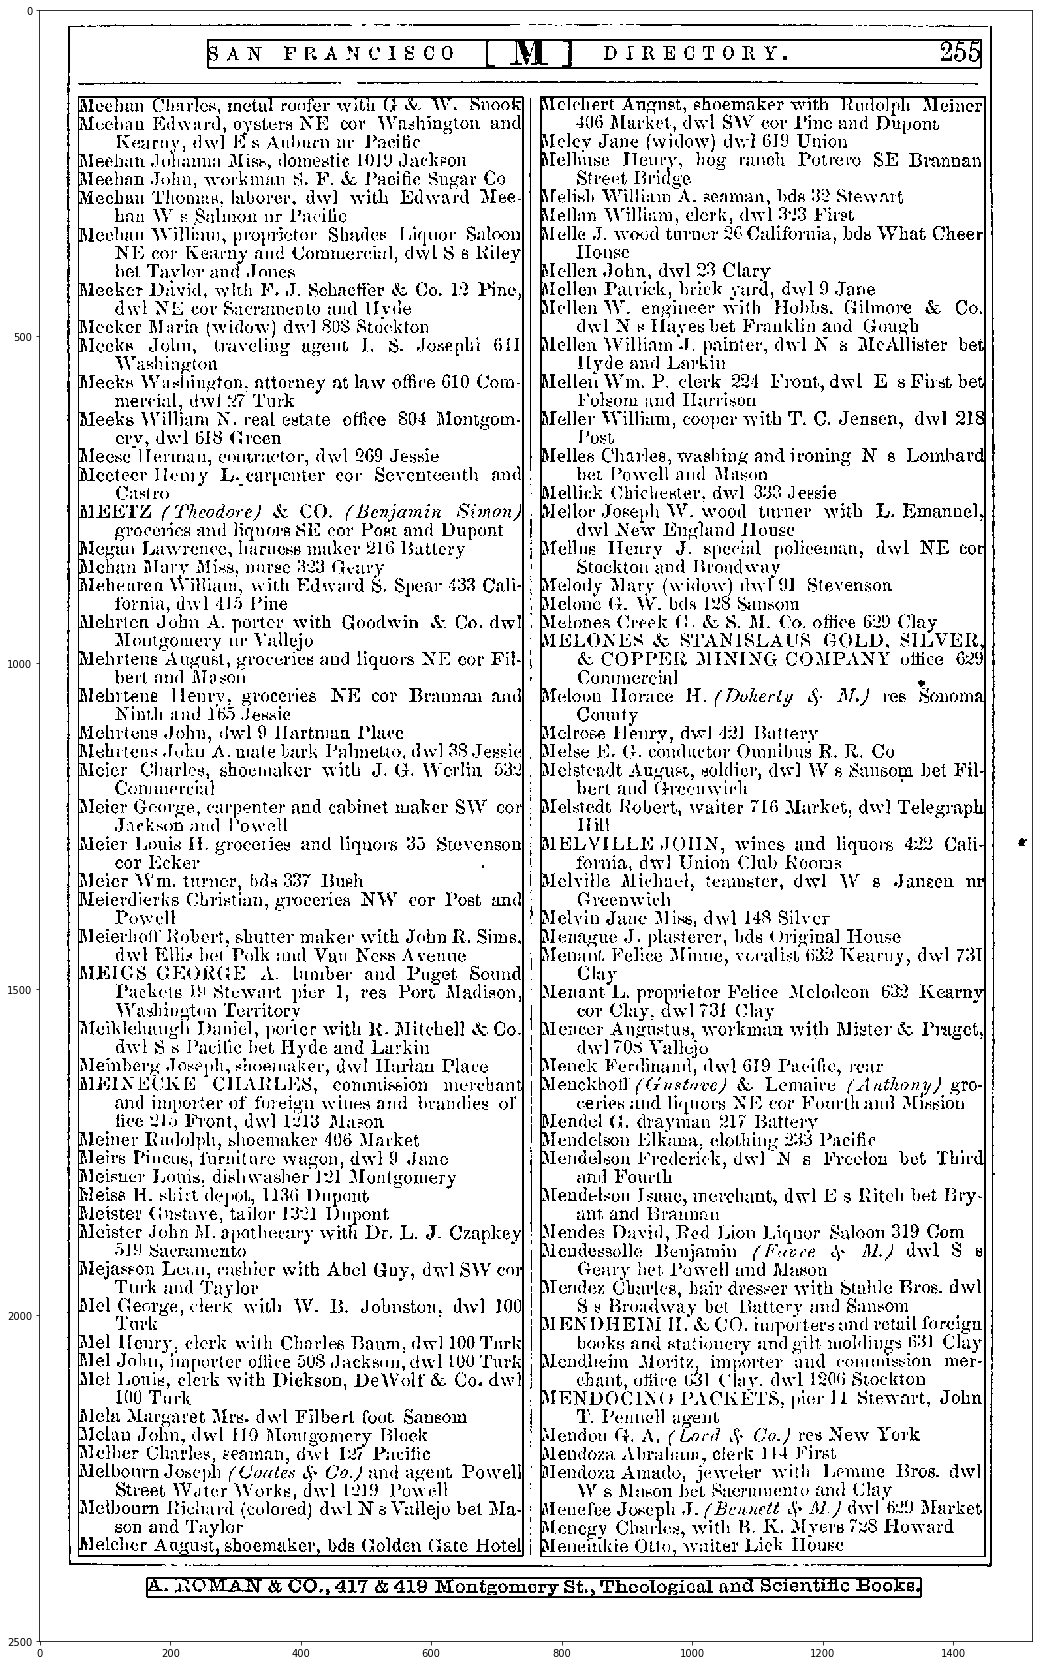

In [219]:
pagenum = 340
img = pdfPageToImg(data['pdf'], pagenum)
blocks = categorizeTwoColumnBlocks(data['contents'][pagenum])
plt.rcParams["figure.figsize"] = (50,30)
try:
    img_mergedBlocks = drawMergedBlocks(img, blocks)
except:
    img_mergedBlocks = img    
plt.imshow(img_mergedBlocks,cmap='gray')
plt.show()

In [132]:
blocks['paragraphs']['header']

['SAN FRANCISCO', '[ Mo] pirecrory.', '2 6 5']

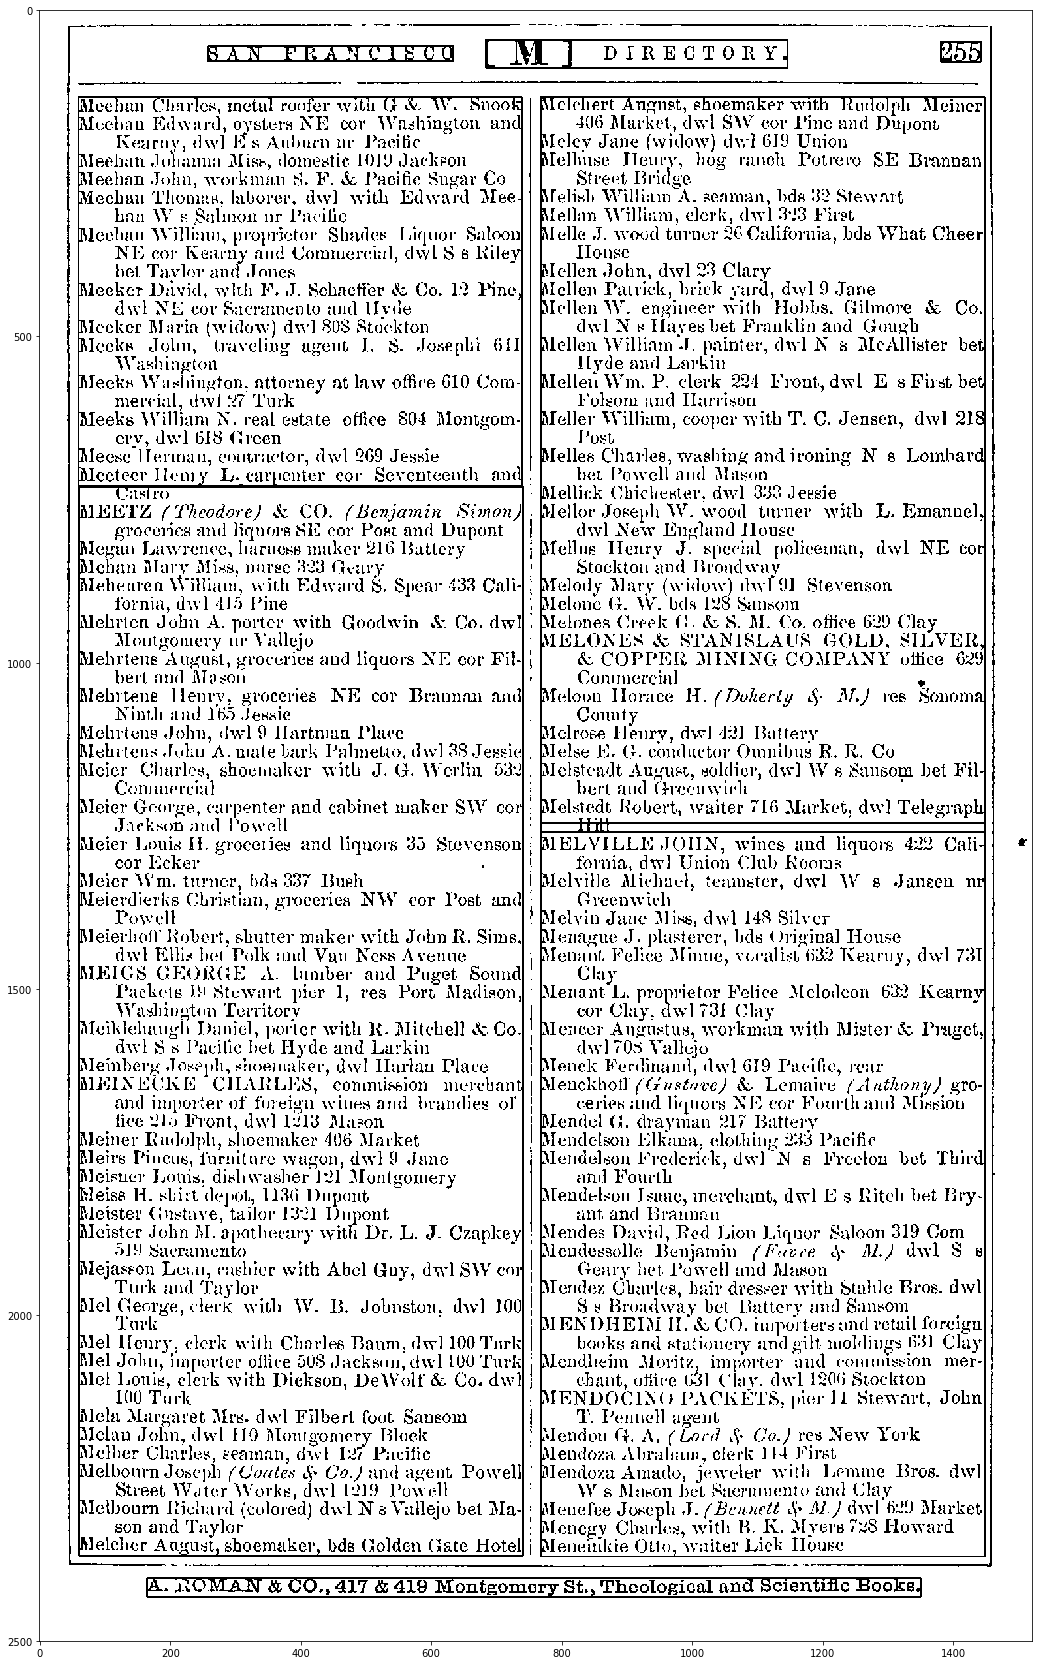

In [220]:
pagenum = 340
img = pdfPageToImg(data['pdf'], pagenum)
blocks = categorizeTwoColumnBlocks(data['contents'][pagenum])
plt.rcParams["figure.figsize"] = (50,30)
try:
    img_blocks = drawBlocks(img, data['contents'][pagenum])
except:
    img_blocks = img    
plt.imshow(img_blocks,cmap='gray')
plt.show()

 1. Determine whether a page is of a 'two-column' format (e.g., p.342)
 2. Identify blocks that are the components of this format (e.g., p. 342, blocks 4 and 9 are columns, block 2 is the header and block 12 is the footer).
 3. Find erroneous blocks (e.g., p.342, block 6, containing a single '|').
 4. Fix improperly parsed blocks (e.g., p.342 block 4 needs re-parsing into paragraphs).

In [212]:
data['contents'][342].keys()
data['contents'][342]['blockstats']
data['contents'][342]['paragraphs'][9]
data['contents'][342]['data'][data['contents'][342]['data'].block_num==4]
#data['contents'][342]['boxes']

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
21,5,1,4,1,1,1,67,142,93,21,77,Merritt
22,5,1,4,1,1,2,180,141,96,28,90,"Martin,"
23,5,1,4,1,1,3,297,145,129,26,96,"carpenter,"
24,5,1,4,1,1,4,447,140,49,23,40,dw]
25,5,1,4,1,1,5,515,140,37,23,96,SE
26,5,1,4,1,1,6,570,148,39,14,96,cor
27,5,1,4,1,1,7,627,140,58,22,96,Pine
28,5,1,4,1,1,8,702,140,45,22,96,and
30,5,1,4,1,2,1,124,170,99,23,94,Battery
32,5,1,4,1,3,1,67,198,92,22,92,Merritt


In [97]:
blocks

{'mergedblocks': {'header': {'top_at': 79,
   'bottom_at': 122,
   'left_at': 279,
   'right_at': 1462,
   'width': 1183,
   'height': 43},
  'footer': {'top_at': 2438,
   'bottom_at': 2466,
   'left_at': 56,
   'right_at': 1470,
   'width': 1414,
   'height': 28},
  'leftcol': {'top_at': 168,
   'bottom_at': 2398,
   'left_at': 73,
   'right_at': 760,
   'width': 687,
   'height': 2230},
  'rightcol': {'top_at': 167,
   'bottom_at': 2406,
   'left_at': 780,
   'right_at': 1465,
   'width': 685,
   'height': 2239}},
 'blockstats': {'header':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  2          1       2      88        113      279       652
  3          1       3      79        122      702      1165
  4          1       1      82        112     1401      1462,
  'footer':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  11         1  

In [68]:
contents[0].keys()

dict_keys(['blockstats', 'paragraphs', 'data', 'boxes', 'pagenum'])

In [92]:
blocks

{'mergedblocks': {'header': {'top_at': 79,
   'bottom_at': 122,
   'left_at': 279,
   'right_at': 1462,
   'width': 1183,
   'height': 43},
  'footer': {'top_at': 2438,
   'bottom_at': 2466,
   'left_at': 56,
   'right_at': 1470,
   'width': 1414,
   'height': 28},
  'leftcol': {'top_at': 168,
   'bottom_at': 2398,
   'left_at': 73,
   'right_at': 760,
   'width': 687,
   'height': 2230},
  'rightcol': {'top_at': 167,
   'bottom_at': 2406,
   'left_at': 780,
   'right_at': 1465,
   'width': 685,
   'height': 2239}},
 'blocks': {'header':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  2          1       2      88        113      279       652
  3          1       3      79        122      702      1165
  4          1       1      82        112     1401      1462,
  'footer':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  11         1      